In [16]:
import importlib, model, networks, linsat, utils, MIP_solvers, datasetgen
importlib.reload(model)
importlib.reload(networks)
importlib.reload(linsat)
importlib.reload(utils)
importlib.reload(MIP_solvers)
importlib.reload(datasetgen)

<module 'datasetgen' from '/Users/rezaramezanpour/Downloads/hyp-sched-main-5/datasetgen.py'>

In [63]:
from utils import get_hyperedges, get_data, get_H, check_feasibility, gumbel_linsat_layer
from model import CustomLossBatch, utility_fn, train_handler
from datagen import generate_data
from linsat import linsat_layer_modified
import torch
from torch import nn
import time
import numpy as np
import pickle
import matplotlib.pyplot as plt
from greedy_solvers import gready_scheduler
from networks import MLP
from MIP_solvers import ipopt_solver, gekko_apopt_solver
from torch.utils.data import Dataset, DataLoader
from datasetgen import get_hyper_dataset
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd


# Parameters

In [64]:
# Step 1: Define problem parameters
V_H = 10  # Number of nodes (links)
E_H = 5   # Number of hyperedges
# N = 0.1  # Noise power
N_db = -136.87  # dB
N = 10**(N_db/10)
theta = 10  # Thresholds for hyperedges
k = 5  # max hyperedge cardinality
test_samples = 100
xy_lim = 4000


# Exhaustive Search Solver

In [65]:
# exhaustive search
def exh_solver(V_H, E_H, N, I, hyperedges):
    best_throughput = 0
    best_schedule = None
    for i in range(2**V_H):
        schedule = np.array([int(x) for x in bin(i)[2:].zfill(V_H)])  # Numpy is faster than torch
        throughput = 0
        # check if the schedule satisfies the hyperedge constraints
        valid_schedule = True
        for hyperedge in hyperedges:
            non_zero_idx = np.nonzero(hyperedge)[0]
            is_not_trivial = len(non_zero_idx) > 1
            if sum(schedule[non_zero_idx]) == len(non_zero_idx) and is_not_trivial:
                valid_schedule = False
                break
        
        if not valid_schedule:
            continue
        # calculate throughput
        for i in range(V_H):
            interference = sum(schedule[j] * I[i, j] for j in range(V_H) if j != i)
            denominator = N[i] + interference
            throughput += np.log2(1+(I[i,i] * schedule[i]) / denominator)
        # print(schedule, throughput)
        if throughput > best_throughput:
            best_throughput = throughput
            best_schedule = schedule

    return best_throughput, best_schedule
        

# HGNN 
## Weights

In [66]:
def get_learnable_parameters(V_H, device):
    hidden_dim = [15, 15, 1]  # 3 layers
    theta_1 = torch.empty(V_H, hidden_dim[0], dtype=torch.float64, requires_grad=True, device=device)
    torch.nn.init.xavier_uniform_(theta_1)
    theta_2 = torch.empty(hidden_dim[0], hidden_dim[1], dtype=torch.float64, requires_grad=True, device=device)
    torch.nn.init.xavier_uniform_(theta_2)
    theta_3 = torch.empty(hidden_dim[1], hidden_dim[2], dtype=torch.float64, requires_grad=True, device=device)
    torch.nn.init.xavier_uniform_(theta_3)
    theta_HGNN = [theta_1, theta_2, theta_3]
    return theta_HGNN

## Model

In [67]:
def HGNN(X, Dv_inv, De_inv, H, W, theta, batch_norm=[]):
    theta_1, theta_2, theta_3 = theta
    Xbar1 = Dv_inv @ H @ W @ De_inv @ H.transpose(1, 2) @ Dv_inv @ X @ theta_1.unsqueeze(0)
    X1 = torch.nn.functional.relu(Xbar1)
    if len(batch_norm)>0:
        bn0 = batch_norm[0]
        X1_t = X1.transpose(2, 1)  # Batch norm expects [batch, feat_channels, ...]
        X1_t = bn0(X1_t)
        X1 = X1_t.transpose(2, 1)
    Xbar2 = Dv_inv @ H @ W @ De_inv @ H.transpose(1, 2) @ Dv_inv @ X1 @ theta_2.unsqueeze(0)
    X2 = torch.nn.functional.relu(Xbar2)
    if len(batch_norm)>0:
        X2_t = X2.transpose(2, 1)  # Batch norm expects [batch, feat_channels, ...]
        bn1 = batch_norm[1]
        X2_t = bn1(X2_t)
        X2 = X2_t.transpose(2, 1)
    Xbar3 = Dv_inv @ H @ W @ De_inv @ H.transpose(1, 2) @ Dv_inv @ X2 @ theta_3.unsqueeze(0)
    X3 = torch.nn.functional.sigmoid(Xbar3)
    X3 = X3.squeeze()
    return X3

# Runtime Comparison

In [70]:
from tqdm import tqdm

In [72]:
exhaustive_search_runtime = []
greedy1_search_runtime = []
greedy2_search_runtime = []
apopt_search_runtime = []
mlp_greedy1_runtime = []
hypergnn_greed1_runtime = []
hypergnn_gumbel_runtime = []

bn1 = nn.BatchNorm1d(15, momentum=0.05, dtype=torch.float64)  # dims match those of HGNN
bn2 = nn.BatchNorm1d(15, momentum=0.05, dtype=torch.float64)
bn = [bn1, bn2]


V_H_list = [10, 15, 20]
Samples = 50
for V_H in tqdm(V_H_list):
    dataset_samples = get_hyper_dataset(V_H, N, xy_lim, theta, k, Samples)

    sample_loader = DataLoader(dataset_samples, batch_size=1, shuffle=False)

    # exhaustive search
    if V_H <= 15:
        start = time.time()
        for sample in sample_loader:
            X, _, _, H, _ = sample
            best_throughput, best_schedule = exh_solver(V_H, V_H, V_H*[N], X[0], H[0].numpy())
        end = time.time()
        exhaustive_search_runtime.append((end-start)/Samples)


    # greedy1 search
    start = time.time()
    for (X, Dv_inv, De_inv, H, W) in sample_loader:
        z = torch.ones([X.shape[0], V_H])
        # w utility
        zw = gready_scheduler(z, X.transpose(2, 1), H.transpose(2, 1), N, False)
    end = time.time()
    greedy1_search_runtime.append((end-start)/Samples)


    # greedy2 search
    start = time.time()
    for (X, Dv_inv, De_inv, H, W) in sample_loader:
        z = torch.ones([X.shape[0], V_H])
        # w utility
        zw = gready_scheduler(z, X.transpose(2, 1), H.transpose(2, 1), N, True)
    end = time.time()
    greedy2_search_runtime.append((end-start)/Samples)

    # apopt search
    if V_H <= 15:
        start = time.time()
        for (X, Dv_inv, De_inv, H, W) in sample_loader:
            best_throughput = gekko_apopt_solver(V_H, V_H, V_H*[N], X[0].numpy(), H[0].numpy())
        end = time.time()
        apopt_search_runtime.append((end-start)/Samples)
    


    # mlp_greedy1_runtime
    mlp_model = MLP(V_H)
    start = time.time()
    for (X, Dv_inv, De_inv, H, W) in sample_loader:
        z = mlp_model(X.view(-1, V_H*V_H))
        # Linsat 
        RHS_const = H.transpose(2, 1).sum(dim=2) - 1
        LHS_const = H.transpose(2, 1)
        z = linsat_layer_modified(z.float(), A=LHS_const.float(), b=RHS_const.float(), tau=1, max_iter=1000, dummy_val=0, no_warning=False, grouped=False).double()

        # base utility
        zwo = gready_scheduler(z, X.transpose(2, 1), H.transpose(2, 1), N, False)
    end = time.time()
    mlp_greedy1_runtime.append((end-start)/Samples)

    
    # hypergnn_greed1_runtime
    theta_HGNN = get_learnable_parameters(V_H, 'cpu')
    start = time.time()
    for (X, Dv_inv, De_inv, H, W) in sample_loader:
        z = HGNN(X, Dv_inv, De_inv, H, W, theta_HGNN, bn)
        # Linsat 
        RHS_const = H.transpose(2, 1).sum(dim=2) - 1
        LHS_const = H.transpose(2, 1)
        z = linsat_layer_modified(z.float(), A=LHS_const.float(), b=RHS_const.float(), tau=1, max_iter=1000, dummy_val=0, no_warning=False, grouped=False).double()
        # wo utility
        zwo = gready_scheduler(z.unsqueeze(0), X.transpose(2, 1), H.transpose(2, 1), N, False)
    end = time.time()
    hypergnn_greed1_runtime.append((end-start)/Samples)

    # hypergnn_gumbel_runtime
    theta_HGNN = get_learnable_parameters(V_H, 'cpu')
    gumbel_samples = 50
    start = time.time()
    for (X, Dv_inv, De_inv, H, W) in sample_loader:
        z = HGNN(X, Dv_inv, De_inv, H, W, theta_HGNN, bn)
        # Linsat 
        RHS_const = H.transpose(2, 1).sum(dim=2) - 1
        LHS_const = H.transpose(2, 1)
        z = gumbel_linsat_layer(z.unsqueeze(0), A=LHS_const.float(), b=RHS_const.float(), tau=1, max_iter=1000, noise_fact=1., sample_num=gumbel_samples)
        # base utility
        # round z to the nearest integer
        utility_max = torch.zeros(z.shape[1])
        for i in range(z.shape[0]):
            # keep the maximum utility
            zwo = gready_scheduler(z[i], X.transpose(2, 1), H.transpose(2, 1), N, False)
            utility_max = torch.max(utility_max, utility_fn(zwo, X, N))
    end = time.time()
    hypergnn_gumbel_runtime.append((end-start)/Samples)











100%|██████████| 3/3 [11:17<00:00, 225.69s/it]


Exhaustive search for 20 users took more than (365 - 11)*60/Samples

In [76]:
exhaustive_search_runtime.append((365 - 11)*60/Samples)

Apopt fail to compute above 20 users

In [77]:
apopt_search_runtime.append(apopt_search_runtime[-1])

/Users/rezaramezanpour/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/rezaramezanpour/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/rezaramezanpour/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/rezaramezanpour/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarn

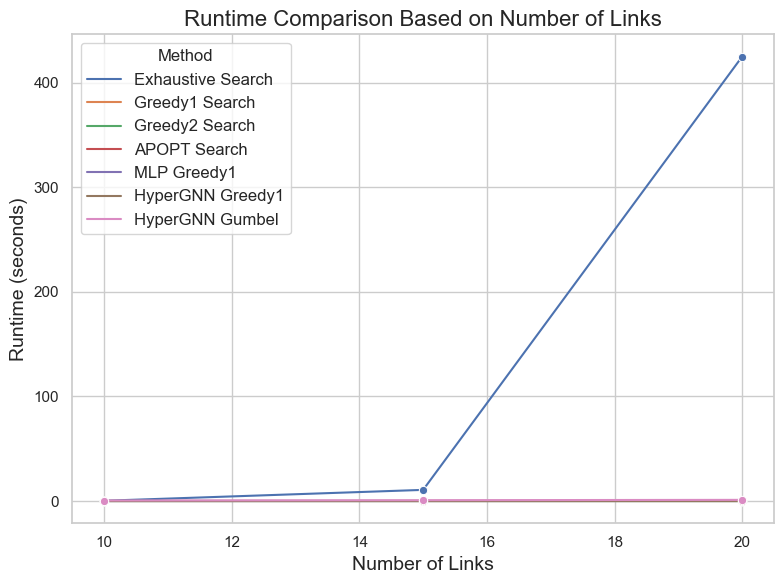

In [78]:


data = {
    "Number of Links": V_H_list * 7,
    "Runtime": (
        exhaustive_search_runtime +
        greedy1_search_runtime +
        greedy2_search_runtime +
        apopt_search_runtime +
        mlp_greedy1_runtime +
        hypergnn_greed1_runtime +
        hypergnn_gumbel_runtime
    ),
    "Method": (
        ["Exhaustive Search"] * 3 +
        ["Greedy1 Search"] * 3 +
        ["Greedy2 Search"] * 3 +
        ["APOPT Search"] * 3 +
        ["MLP Greedy1"] * 3 +
        ["HyperGNN Greedy1"] * 3 +
        ["HyperGNN Gumbel"] * 3
    )
}

df = pd.DataFrame(data)

# Plot
plt.figure(figsize=(8, 6))
sns.lineplot(data=df, x="Number of Links", y="Runtime", hue="Method", marker="o")
plt.title("Runtime Comparison Based on Number of Links", fontsize=16)
plt.xlabel("Number of Links", fontsize=14)
plt.ylabel("Runtime (seconds)", fontsize=14)
plt.legend(title="Method", fontsize=12)
plt.grid(visible=True)
plt.tight_layout()
plt.show()

/Users/rezaramezanpour/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/rezaramezanpour/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/rezaramezanpour/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/rezaramezanpour/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarn

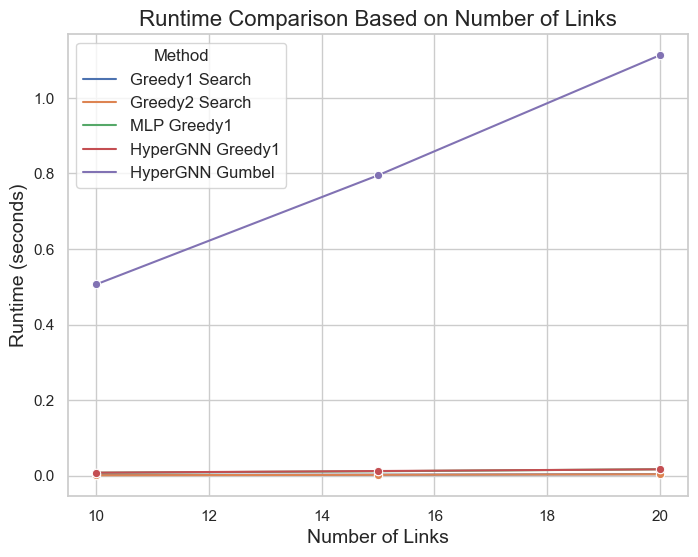

In [79]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

data = {
    "Number of Links": V_H_list * 5,
    "Runtime": (
        greedy1_search_runtime +
        greedy2_search_runtime +
        mlp_greedy1_runtime +
        hypergnn_greed1_runtime +
        hypergnn_gumbel_runtime
    ),
    "Method": (
        ["Greedy1 Search"] * 3 +
        ["Greedy2 Search"] * 3 +
        ["MLP Greedy1"] * 3 +
        ["HyperGNN Greedy1"] * 3 +
        ["HyperGNN Gumbel"] * 3
    )
}

df = pd.DataFrame(data)

# Plot
plt.figure(figsize=(8, 6))
sns.lineplot(data=df, x="Number of Links", y="Runtime", hue="Method", marker="o")
plt.title("Runtime Comparison Based on Number of Links", fontsize=16)
plt.xlabel("Number of Links", fontsize=14)
plt.ylabel("Runtime (seconds)", fontsize=14)
plt.legend(title="Method", fontsize=12)
plt.grid(visible=True)
plt.show()

In [80]:
# save these values
with open('runtime_comparison.pkl', 'wb') as f:
    pickle.dump({
        "exhaustive_search_runtime": exhaustive_search_runtime,
        "greedy1_search_runtime": greedy1_search_runtime,
        "greedy2_search_runtime": greedy2_search_runtime,
        "apopt_search_runtime": apopt_search_runtime,
        "mlp_greedy1_runtime": mlp_greedy1_runtime,
        "hypergnn_greed1_runtime": hypergnn_greed1_runtime,
        "hypergnn_gumbel_runtime": hypergnn_gumbel_runtime
    }, f)